# Рекомендация тарифов

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы . Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
# Импортируем библиотеки
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.dummy import DummyClassifier

In [2]:
# Откроем файл
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Посмотрим на распределение значений целевого признака.

In [3]:
print(f"Доля пользователей перешедших на тариф Ultra: {len(df.loc[df['is_ultra'] == 1, 'is_ultra']) / df.shape[0]:.0%}")

Доля пользователей перешедших на тариф Ultra: 31%


Набор данных не сбалансирован, с вероятностью 31% пользователь перешел на тариф *ultra*. Минимальная задача модели - достигнуть значение точности больше 31%. Так как предобработка не требуется, то сразу займемся подготовкой к обучению моделей.

## Разбейте данные на выборки

In [4]:
# Отделим признаки от целевого признака
features = df.drop(columns=['is_ultra'])
target = df['is_ultra']
# Cначала розобьем датасет на тестовую (20%) и тренировочную выборки (80%)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345
    ) 
# Дополнительно разделим тренировочную выборку на тренировочную (25% от 80%) и валидационную (75% от 80%)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345
    )
# Проверим разбиение
print(f"Размер тестовой выборки: {(features_test.shape[0] / df.shape[0]):.0%}")
print(f"Размер валидационной выборки: {(features_valid.shape[0] / df.shape[0]):.0%}")
print(f"Размер тренировочной выборки: {(features_train.shape[0] / df.shape[0]):.0%}")

Размер тестовой выборки: 20%
Размер валидационной выборки: 20%
Размер тренировочной выборки: 60%


## Исследуем модели

### Дерево решений

Accuracy лучшей модели равно 77% с глубиной 7


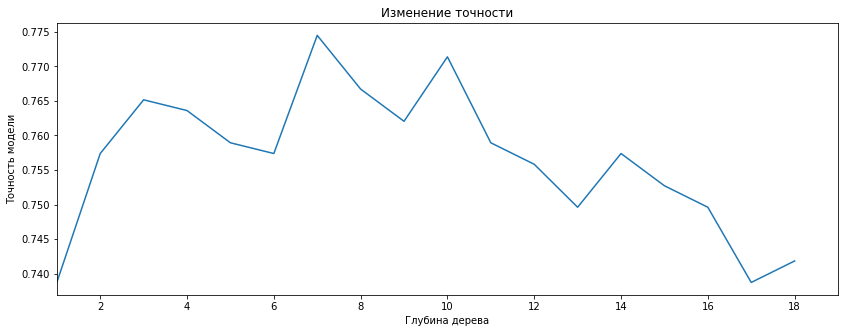

In [5]:
# Создадим модель класа DecisionTree и обучим ее, меняя гиперпараметры
accuracy = []
best_acc = 0
max_depth = 0
best_DTC = None
n = 19
for depth in range(1,n):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    acc = accuracy_score(target_valid, predictions)
    accuracy.append(acc) 
    if acc > best_acc:
        best_DTC = model
        best_acc = acc
        max_depth = depth
print(f"Accuracy лучшей модели равно {best_acc:.0%} с глубиной {max_depth}")
plt.figure(figsize=(14,5))
plt.title('Изменение точности')
plt.xlabel('Глубина дерева')
plt.ylabel('Точность модели')
plt.xlim(1,n)
plt.plot(list(range(1,n)),accuracy)

**Вывод:** Максимальную accuracy достигает модель с глубиной 7. После этого начинается переобучение модели

### Случайный лес

Accuracy лучшей модели равно 80% с количеством деревьев 20 и глубиной 15


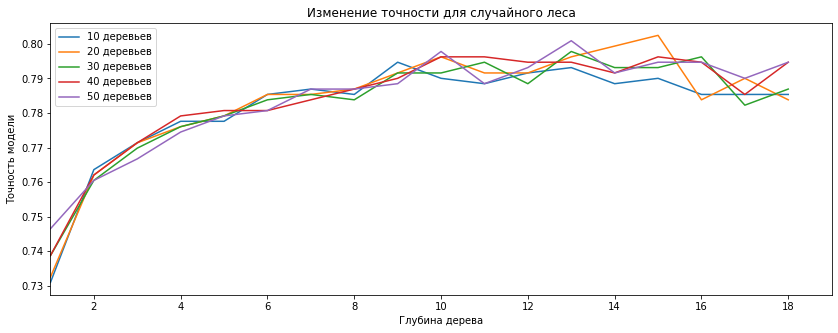

In [6]:
# Создадим модель класа RandomForest и обучим ее, меняя гиперпараметры
best_acc = 0
max_depth = 0
estimators = 0
best_RFC = None
x = 10
y = 51
n = 19
plt.figure(figsize=(14,5))
plt.title(f'Изменение точности для случайного леса')
plt.xlabel('Глубина дерева')
plt.ylabel('Точность модели')
plt.xlim(1, n)
for n_est in range(x,y,10):
    accuracy = []
    for depth in range(1,n):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        acc = accuracy_score(target_valid, predictions)
        accuracy.append(acc) 
        if acc > best_acc:
            best_RFC = model
            best_acc = acc
            max_depth = depth 
            estimators = n_est   
    plt.plot(list(range(1, n)),accuracy, label=str(n_est)+' деревьев')
plt.legend()
print(f"Accuracy лучшей модели равно {best_acc:.0%} с количеством деревьев {estimators} и глубиной {max_depth}")

**Вывод:** Количество деревьев не сильно влияет на точность (у всех максимальное значение +/- 80%). Наибольшей точностью обладает случайный лес с 20 деревьями глубиной 15.

### Логистическая регрессия

In [7]:
LR = LogisticRegression(random_state=12345, penalty='l1')
LR.fit(features_test, target_test)
predictions = LR.predict(features_valid)
print(f"Accuracy логистической регрессии равно {accuracy_score(target_valid, predictions):.0%}")

Accuracy логистической регрессии равно 73%


**Вывод:** Изменив тип регуляризации на L1, получили прирост точности на 2% до 73%.

## Проверим модель на тестовой выборке

Сравним точности для всех лучших моделей на тестовой выборке.

In [8]:
models = [best_DTC, best_RFC, LR]
for model in models:
    predictions = model.predict(features_test)
    acc = accuracy_score(target_test, predictions)
    print(f"Accuracy модели {type(model).__name__} на тестовой выборке составляет {acc:.0%}")

Accuracy модели DecisionTreeClassifier на тестовой выборке составляет 79%
Accuracy модели RandomForestClassifier на тестовой выборке составляет 79%
Accuracy модели LogisticRegression на тестовой выборке составляет 75%


**Выводы:** На тестовой выборке у дерева решений и логистического регрессора точность повысилась на 2%. Это означает, что модель чуть-чуть не доучилась на тренировочной выборке и не нашла все закономерности, возможно, стоит добавить дополнительные признаки в данныe. 

Несмотря на лучшие результаты на валидационной выборке, случайный лес выдает на тестовой выборке те же значения точности, что дерево решений. При этом точность упала на 1 % у леса, данный факт означает, что случайный лес не испытал переобучения.

Таким образом, дерево решений и случайный лес достигают точности в 75% на всех этапах проверки. Однако, логистическая регрессия на этапе валидации выдает результат ниже порога.

Окончательный выбор между деревом решений и случайном лесом зависит от временных требований. Если необходимо быстро и часто дообучать модель, то стоит отсановиться на дереве решений, если же выигрыш в несколько процентов имеет смысл, а время обучения модели нет, то случайный лес подойдет.

## Проверим модели на адекватность

Исследуемы датасет не является сбалансированным, в данных только 31% пользователей с тарифом *Ultra*. Для более детального анализа качества модели можно использовать метрики *recall* и *precision*.

In [9]:
# Проанализируем метрику precision
models = [best_DTC, best_RFC, LR]
for model in models:
    predictions = model.predict(features_test)
    acc = precision_score(target_test, predictions)
    print(f"Precision модели {type(model).__name__} на тестовой выборке составляет {acc:.0%}")

Precision модели DecisionTreeClassifier на тестовой выборке составляет 77%
Precision модели RandomForestClassifier на тестовой выборке составляет 70%
Precision модели LogisticRegression на тестовой выборке составляет 93%


In [10]:
# Проанализируем метрику recall
models = [best_DTC, best_RFC, LR]
for model in models:
    predictions = model.predict(features_test)
    acc = recall_score(target_test, predictions)
    print(f"Recall модели {type(model).__name__} на тестовой выборке составляет {acc:.0%}")

Recall модели DecisionTreeClassifier на тестовой выборке составляет 44%
Recall модели RandomForestClassifier на тестовой выборке составляет 52%
Recall модели LogisticRegression на тестовой выборке составляет 19%


Сопоставим результаты моделей с моделью, которая выдает одно число. В датасете больше нулевых значений, поэтому создадим модель, заполняюшую все нулями.

In [11]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)
predictions = dummy_model.predict(features_test)
print(f"Accuracy 'глупой' модели: {accuracy_score(target_test, predictions):.0%}")

Accuracy 'глупой' модели: 70%


**Вывод:** На основе других метрик ситуация меняется координально. Модель логистической регрессии в большей мере присваивает объектам правильные классы (согласно precision). При этом, логистическая регрессия находит правильно только 19% объектов, принадлежащих к классу пользователей тарифа *Ultra* (согласно *recall*).

Также все модели прошли тест на адекватность, имея значения точности свыше 70%